<center>
<img src="https://habrastorage.org/web/677/8e1/337/6778e1337c3d4b159d7e99df94227cb2.jpg"/>
## Специализация "Машинное обучение и анализ данных"
<center>Автор материала: программист-исследователь Mail.Ru Group, старший преподаватель Факультета Компьютерных Наук ВШЭ [Юрий Кашницкий](https://yorko.github.io/)

# <center>  Capstone проект №1 <br> Идентификация пользователей по посещенным веб-страницам
<img src='http://i.istockimg.com/file_thumbview_approve/21546327/5/stock-illustration-21546327-identification-de-l-utilisateur.jpg'>

# <center>Неделя 3. Визуальный анализ данных и построение признаков

На 3 неделе мы займемся визуальным анализом данных и построением признаков. Сначала мы вместе построим и проанализируем несколько признаков, потом Вы сможете сами придумать и описать различные признаки. 

**План 3 недели:**
 - Часть 1. Построение признаков
 - Часть 2. Визуальный анализ данных
 - Часть 3. Дальнейшее построение признаков
 - Часть 4. Проверка построенных признаков

**В этой части проекта Вам могут быть полезны видеозаписи следующих лекций курса "Поиск структуры в данных":**
   - [Задача визуализации](https://www.coursera.org/learn/unsupervised-learning/lecture/hlvlT/zadacha-vizualizatsii)
   - [Визуализация данных в sklearn](https://www.coursera.org/learn/unsupervised-learning/lecture/ityMo/vizualizatsiia-dannykh-v-sklearn)
   
**Также в задании будет использоваться библиотека Seaborn (ее можно дополнительно установить командой *pip install seaborn*), будет полезно обращаться к документациям [Matplotlib](http://matplotlib.org/users/) и [Seaborn](http://seaborn.pydata.org/), а также к примерам визуализации, описанным на StackOverflow.**



### Задание
1. Заполните код в этой тетрадке 
2. Если вы проходите специализацию Яндеса и МФТИ, пошлите тетрадку в соответствующем Peer Review. <br> Если вы проходите курс ODS, выберите ответы в [веб-форме](https://docs.google.com/forms/d/1EbjK7-hF-Gepi6RH-K5I2XeiYGRoY0LNDx03QmLu9Xo). 

## Часть 1. Построение признаков

In [1]:
from __future__ import division, print_function
# отключим всякие предупреждения Anaconda
import warnings
warnings.filterwarnings('ignore')
from glob import glob
import os
from tqdm import tqdm_notebook
import numpy as np
import pandas as pd
pd.set_option('display.max.columns', 25)
import pickle
#pip install seaborn
import seaborn as sns
%matplotlib inline
from matplotlib import pyplot as plt

In [2]:
# Поменяйте на свой путь к данным
PATH_TO_DATA = '/content/' 

**Создайте на основе функций *prepare_train_set* и *prepare_sparse_train_set_window*  новую – *prepare_train_set_with_fe*, (от "feature engineering"), создайте следующие признаки:**
- `session_timespan` – продолжительность сессии (разница между максимальным и минимальным временем посещения сайтов в сессии, в секундах)
- `#unique_sites` – число уникальных сайтов в сессии 
- `start_hour` – час начала сессии (то есть час в записи минимального timestamp среди десяти)
- `day_of_week` – день недели (то есть день недели в записи минимального timestamp среди десяти)

Функция должна возвращать новый DataFrame (как возвращала функция *prepare_train_set*), только признаков должно быть на 4 больше. Порядок, в котором добавляются признаки: *site1*, ... *site10*, *session_timespan*, *#unique_sites*, *start_hour*, *day_of_week* и *user_id* (это видно и чуть ниже по тому, как функция вызывается).

In [3]:
def prepare_train_set_with_fe(path_to_csv_files, site_freq_path, feature_names,
                                    session_length=10, window_size=10):
  
  files = sorted(glob(path_to_csv_files))
  freq_dict = pd.read_pickle(site_freq_path)

  df = pd.concat([pd.read_csv(f) for f in files], 
                keys=[int(f.split('/')[-1][-8:-4]) for f in files],
                names=['user_id'],
                )

  df.site = df.site.map(freq_dict).apply(lambda x: x[0])
  df.timestamp = pd.to_datetime(df.timestamp)

  data = []
  # time_diff = []
  session_timespan = []
  unique_sites = []
  start_hour = []
  day_of_week = []
  y = []

  for user_id in df.index.get_level_values(0).unique():
    user_df = df.loc[user_id]

    for i in range(0, len(user_df), window_size):
      session = user_df.site.values[i:i+session_length]
      resid = session_length - len(session)
      unique_sites_by_ses = len(set(session))

      if  resid > 0:
        session = np.append(session, np.zeros(resid, dtype=int)) 

      session_time = user_df.timestamp[i:i+session_length]

      data.append(session)
      # time_diff_arr.append((np.diff(session_time)/1e9).astype(int))
      session_timespan.append((session_time.iloc[-1] - session_time.iloc[0]).total_seconds())
      unique_sites.append(unique_sites_by_ses)
      start_hour.append(session_time.iloc[0].hour)
      day_of_week.append(session_time.iloc[0].weekday())
      y.append(user_id)

  data = np.column_stack((data, session_timespan, unique_sites, start_hour, day_of_week, y)).astype('int32')
  
  df = pd.DataFrame(data = data, columns=feature_names)
  
  return df

**Проверим функцию на игрушечном примере.**

In [4]:
%%time
feature_names = ['site' + str(i) for i in range(1,11)] + \
                ['session_timespan', '#unique_sites', 'start_hour', 
                 'day_of_week', 'target']
                 # ['time_diff' + str(j) for j in range(1,10)] + \
train_data_toy  = prepare_train_set_with_fe(os.path.join(PATH_TO_DATA, 
                                                         '3users/*'), 
                  site_freq_path=os.path.join(PATH_TO_DATA, 
                                              'site_freq_3users.pkl'),
                  feature_names=feature_names, session_length=10)

CPU times: user 23.1 ms, sys: 775 µs, total: 23.9 ms
Wall time: 28.9 ms


In [5]:
train_data_toy

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,session_timespan,#unique_sites,start_hour,day_of_week,target
0,3,2,2,7,2,1,9,6,10,8,7998,8,9,4,1
1,3,1,1,1,0,0,0,0,0,0,60,2,12,4,1
2,3,2,5,5,2,0,0,0,0,0,7935,3,9,4,2
3,4,1,2,1,2,1,1,6,11,4,7998,5,9,4,3
4,4,1,2,0,0,0,0,0,0,0,1471,3,12,4,3


Пример:

In [ ]:
train_data_toy

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,time_diff1,time_diff2,time_diff3,time_diff4,time_diff5,time_diff6,time_diff7,time_diff8,time_diff9,session_timespan,#unique_sites,start_hour,day_of_week,target
0,3,2,2,7,2,1,8,5,9,10,287,1184,6278,186,2,1,2,3,55,7998,8,9,4,1
1,3,1,1,1,0,0,0,0,0,0,2,3,55,0,0,0,0,0,0,60,2,12,4,1
2,3,2,6,6,2,0,0,0,0,0,287,1184,6278,186,0,0,0,0,0,7935,3,9,4,2
3,4,1,2,1,2,1,1,5,11,4,287,1184,6278,186,2,1,2,3,55,7998,5,9,4,3
4,4,1,2,0,0,0,0,0,0,0,287,1184,0,0,0,0,0,0,0,1471,3,12,4,3


**Примените функцию *prepare_train_set_with_fe* к данным по 10 пользователям, укажите *session_length*=10.**

In [6]:
%%time
train_data_10users = prepare_train_set_with_fe(os.path.join(PATH_TO_DATA, 
                                                         '10users/*'), 
                  site_freq_path=os.path.join(PATH_TO_DATA, 
                                              'site_freq_10users.pkl'),
                  feature_names=feature_names, session_length=10)

CPU times: user 3.26 s, sys: 30.3 ms, total: 3.29 s
Wall time: 3.3 s


In [7]:
train_data_10users.head()

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,session_timespan,#unique_sites,start_hour,day_of_week,target
0,193,579,133,3,133,133,3,133,204,133,33,5,8,4,31
1,425,192,681,257,133,31,399,3917,220,55,284,10,8,4,31
2,55,3,55,55,5,294,425,335,900,55,258,7,8,4,31
3,484,3940,484,55,55,55,55,1001,202,123,30,6,8,4,31
4,344,55,5,4088,258,212,3928,2104,679,2104,6,9,8,4,31


**Примените функцию *prepare_train_set_with_fe* к данным по 150 пользователям, укажите *session_length*=10.**

In [8]:
%%time
train_data_150users = prepare_train_set_with_fe(os.path.join(PATH_TO_DATA, 
                                                         '150users/*'), 
                  site_freq_path=os.path.join(PATH_TO_DATA, 
                                              'site_freq_150users.pkl'),
                  feature_names=feature_names, session_length=10)

CPU times: user 32.7 s, sys: 270 ms, total: 33 s
Wall time: 33 s


**Сохраните в pickle-файлы признаки *session_timespan*, *#unique_sites*, *start_hour* и *day_of_week* для 10 и 150 пользователей.**

In [9]:
new_features_10users = train_data_10users[feature_names[-5:-1]]
new_features_150users = train_data_150users[feature_names[-5:-1]]

In [10]:
with open(os.path.join(PATH_TO_DATA, 
                       'new_features_10users.pkl'), 'wb') as new_features_10users_pkl:
    pickle.dump(new_features_10users, new_features_10users_pkl)
with open(os.path.join(PATH_TO_DATA, 
                       'new_features_150users.pkl'), 'wb') as new_features_150users_pkl:
    pickle.dump(new_features_150users, new_features_150users_pkl)

**<font color='red'>Вопрос 1. </font> Выведите медианную продолжительность сессии (*session_timespan*) для сессий 10 пользователей.**

In [11]:
train_data_10users.session_timespan.median()

37.0

**<font color='red'>Вопрос 2. </font> Выведите медианный день недели, в который началась сессия, для сессий 10 пользователей.**

In [12]:
train_data_10users.day_of_week.median()

2.0

**<font color='red'>Вопрос 3. </font>Выведите медианный час начала сессии для сессий 150 пользователей.**

In [13]:
train_data_150users.start_hour.median()

13.0

**<font color='red'>Вопрос 4. </font>Выведите медианное значение числа уникальных сайтов в сессиях 150 пользователей.**

In [14]:
train_data_150users['#unique_sites'].median()

7.0

## Часть 2. Визуальный анализ данных

**Забавы ради, потехи для дадим пользователям имена и ассоциируем с ними цвета.**

In [15]:
id_name_dict = {128: 'Mary-Kate', 39: 'Ashley', 207: 'Lindsey', 127: 'Naomi', 237: 'Avril',
               33: 'Bob', 50: 'Bill', 31: 'John', 100: 'Dick', 241: 'Ed'}
train_data_10users['target'] = train_data_10users['target'].map(id_name_dict)

In [16]:
color_dic = {'Mary-Kate': 'pink', 'Ashley': 'darkviolet', 'Lindsey':'blueviolet', 
             'Naomi': 'hotpink', 'Avril': 'orchid', 
             'Bob': 'firebrick', 'Bill': 'gold', 'John': 'forestgreen', 
             'Dick': 'slategrey', 'Ed':'brown'}

**1. Постройте гистограмму распределения длины сессии в секундах (*session_timespan*). Ограничьте по *x* значением 200 (иначе слишком тяжелый хвост). Сделайте гистограмму цвета *darkviolet*, подпишите оси по-русски.**

Text(0, 0.5, 'Число сессий')

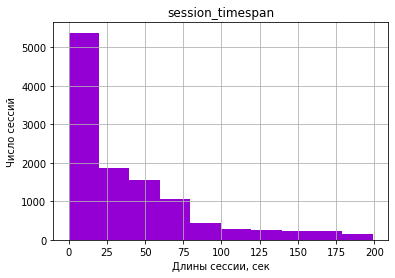

In [17]:
train_data_10users[train_data_10users['session_timespan'] < 200].hist(column='session_timespan', color='darkviolet')
plt.xlabel('Длины сессии, сек')
plt.ylabel('Число сессий')

**2. Постройте гистограмму распределения числа уникальных сайтов в сессии (*#unique_sites*). Сделайте гистограмму цвета *aqua*, подпишите оси по-русски.**

Text(0, 0.5, 'Число сессий')

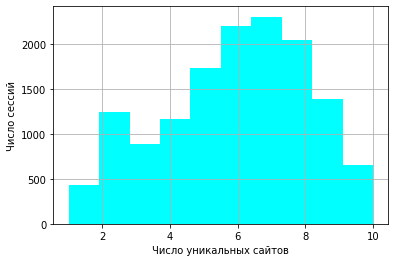

In [18]:
train_data_10users['#unique_sites'].hist(color='aqua')
plt.xlabel('Число уникальных сайтов')
plt.ylabel('Число сессий')

**3. Постройте гистограммы распределения числа уникальных сайтов в сессии (*#unique_sites*) для каждого из 10 пользователей по отдельности. Используйте *subplots*, чтоб разместить все 10 картинок на одной большой. Пометьте легендой каждую картинку, на легенде должно быть написано имя пользователя. Для каждого пользователя раскрасьте гистограмму его/ее цветом (*color_dic*). Подпишите оси по-русски в каждой из 10 гистограмм.**

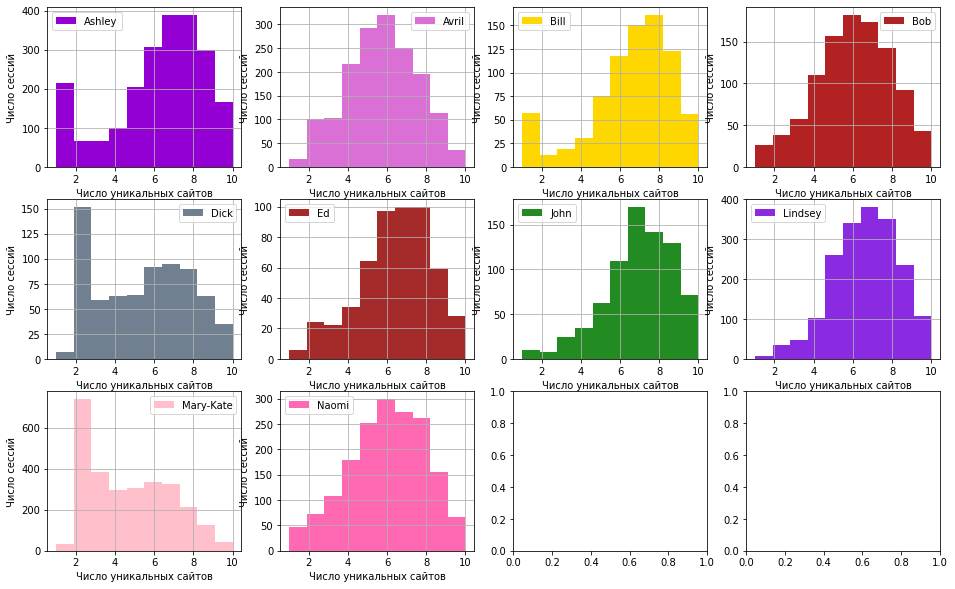

In [19]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))
axs = axes.ravel()

# как вариант, можно и по-другому
for idx, (user, sub_df) in  enumerate(train_data_10users.groupby('target')): 
  sub_df['#unique_sites'].hist(color = color_dic[user], ax = axs[idx])
  axs[idx].set_xlabel('Число уникальных сайтов')
  axs[idx].set_ylabel('Число сессий')
  axs[idx].legend([user])

**4. Постройте гистограмму распределения часа начала сессии (*start_hour*). Сделайте гистограмму цвета *darkgreen*, подпишите оси по-русски.**

Text(0, 0.5, 'Число сессий')

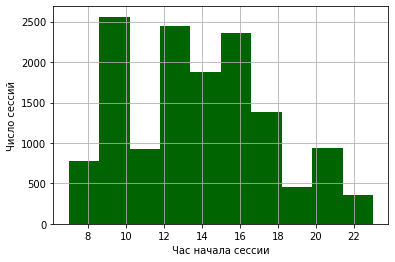

In [20]:
train_data_10users['start_hour'].hist(color='darkgreen')
plt.xlabel('Час начала сессии')
plt.ylabel('Число сессий')

**5. Постройте гистограммы распределения часа начала сессии (*start_hour*) для каждого из 10 пользователей по отдельности. Используйте *subplots*, чтоб разместить все 10 картинок на одной большой. Пометьте легендой каждую картинку, на легенде должно быть написано имя пользователя. Для каждого пользователя раскрасьте гистограмму его/ее цветом (*color_dic*). Подпишите оси по-русски в каждой из 10 гистограмм.**

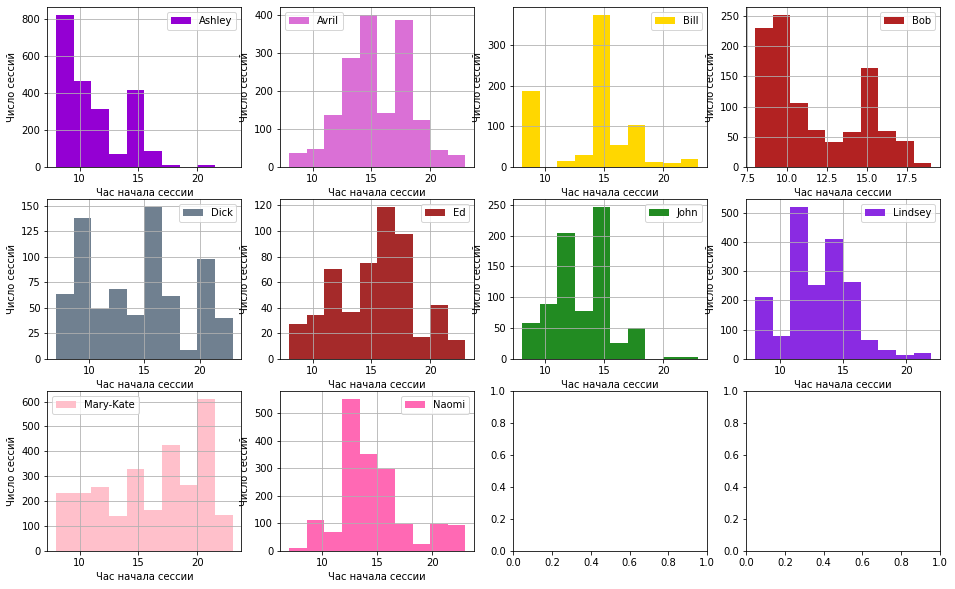

In [21]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))
axs = axes.ravel()

# как вариант, можно и по-другому
for idx, (user, sub_df) in  enumerate(train_data_10users.groupby('target')): 
  sub_df['start_hour'].hist(color = color_dic[user], ax = axs[idx])
  axs[idx].set_xlabel('Час начала сессии')
  axs[idx].set_ylabel('Число сессий')
  axs[idx].legend([user])

**6. Постройте гистограмму распределения дня недели, в который началась сессия (*day_of_week*). Сделайте гистограмму цвета *sienna*, подпишите оси по-русски.**

Text(0, 0.5, 'Число сессий')

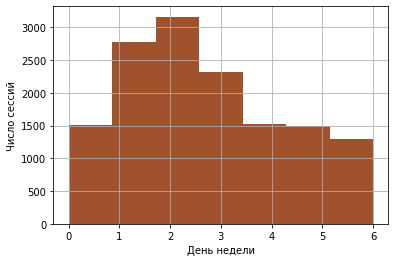

In [22]:
train_data_10users['day_of_week'].hist(color='sienna', bins = 7)
plt.xlabel('День недели')
plt.ylabel('Число сессий')

**7. Постройте гистограммы распределения дня недели, в который началась сессия (*day_of_week*) для каждого из 10 пользователей по отдельности. Используйте *subplots*, чтоб разместить все 10 картинок на одной большой. Измените метки по оси *X* на ['Пн', 'Вт', 'Ср', 'Чт', 'Пт', 'Сб', 'Вс'] – метод *set_xticklabels*. Пометьте легендой каждую картинку, на легенде должно быть написано имя пользователя. Для каждого пользователя раскрасьте гистограмму его/ее цветом (*color_dic*). Подпишите по-русски название каждой из 10 гистограмм.**

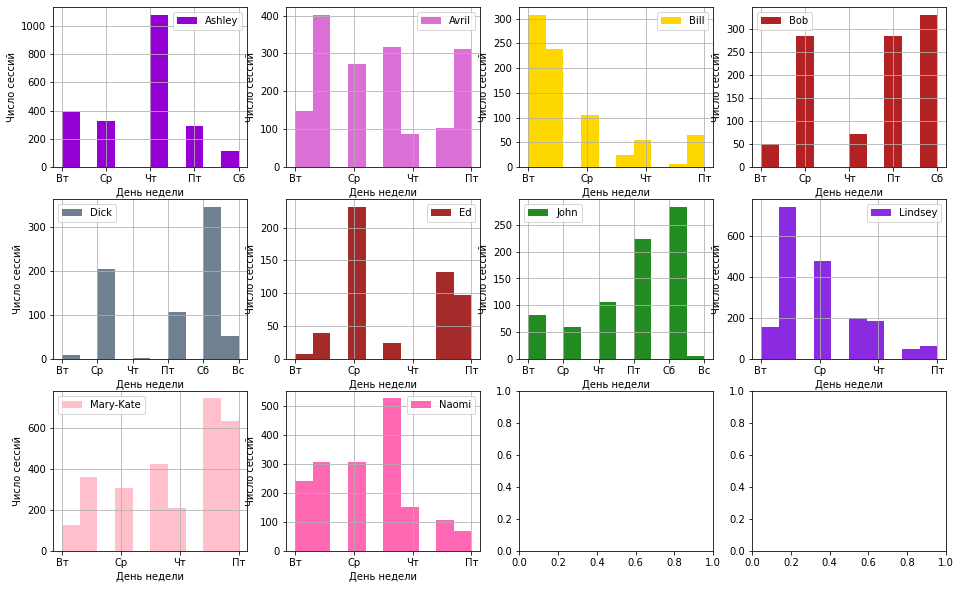

In [23]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))
axs = axes.ravel()

# как вариант, можно и по-другому
for idx, (user, sub_df) in  enumerate(train_data_10users.groupby('target')): 
  sub_df['day_of_week'].hist(color = color_dic[user], ax = axs[idx])
  axs[idx].set_xticklabels(['Пн', 'Вт', 'Ср', 'Чт', 'Пт', 'Сб', 'Вс'])
  axs[idx].set_xlabel('День недели')
  axs[idx].set_ylabel('Число сессий')
  axs[idx].legend([user])

**8. Сделайте выводы про каждого пользователя по построенным графикам.**

Число уникальных сайтов в сессии (`#unique_sites`):
Большинство графиков имеют распределение близкое к нормальному, в некоторых случаях наблюдаются скосы и тяжелые хвосты. Есть смысл использовать преобразование Бокса-Кокса для их нормализации. Диапазон пика распределений - 6-8.

Час начала сессии (`start_hour`). 
Графики имеют полимодальное распределение. В большинстве случаев диапозон пика расположен около 15 часов. Можно выделить 3 группы пользователей: те, кто начинают сессию утром (до 12), днём (с 12 до 18) или вечером(после 18). Это может быть дополнительным признаком в модели.

День недели (`day_of_week`). 
Распределение неоднородно и прерывисто. Имеет смысл попробовать провести дополнительную кластеризацию в данном признаковом простанстве, чтобы получить более стабильные признаки.

**Загрузите сохраненный ранее в pickle-файл частотный словарь сайтов для 10 пользователей. **

In [24]:
site_freq_10users_dict = pd.read_pickle(os.path.join(PATH_TO_DATA, 
                                              'site_freq_10users.pkl'))

**Определите топ-10 самых посещаемых сайтов (*top10_sites*) и соответствующие кол-ва посещений (*top10_freqs*).**

In [25]:
top10_freqs = list(zip(*site_freq_10users_dict.values()))[1][:10]
top10_sites = list(site_freq_10users_dict.keys())[:10]

**9. Нарисуйте *seaborn barplot*, показывающий частоты посещений топ-10 сайтов. Сделайте подписи сайтов вертикальными, иначе они сливаются (*xticks*).**

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 <a list of 10 Text major ticklabel objects>)

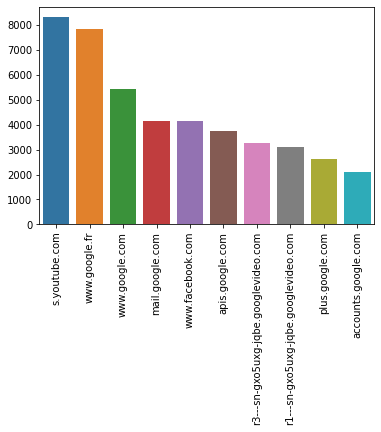

In [26]:
sns.barplot(x=top10_sites, y=top10_freqs)
plt.xticks(rotation=90)

## Часть 3. Дальнейшее построение признаков

Это задание творческое, тут надо придумать, как еще учесть время посещения веб-страниц и прочие признаки. 

На следующей неделе мы будем использовать "мешок" сайтов  для классификации сессий по принадлежности разным пользователям, а эти новые признаки, которые Вы сейчас создадите, потом добавим и посмотрим, улучшается ли модель. Поэтому можно их создать в виде отдельных матриц и сохранить их также отдельно.  

В этой части задания Вы можете построить и визуально исследовать самые разные признаки (ничто фантазию не ограничивает):
- год, месяц и день начала сессии
- час начала сессии (с учетом года, месяца и дня)
- время суток
- среднее время пребывания на сайте, посчитать можно, скажем, для топ-30 популярных сайтов
- индикаторы посещения популярных сайтов (скажем, тоже для топ-30 популярных сайтов)
- частота посещения Facebook
- ...

**Напишите функцию для создания новых признаков и примените ее к исходным данным – каталогам с 10 и 150 файлами. Сделайте это только для набора данных, полученного с параметрами *session_length=10* и *window_size=10*. Сериализуйте полученные матрицы с помощью pickle. Функция может возвращать как только новые признаки, так и старые с новыми. При этом сигнатура функции может быть другой – тут уже свобода выбора.**

In [27]:
def get_part_of_day(hour):
    return (
        'morning' if 5 <= hour <= 11
        else
        'afternoon' if 12 <= hour <= 17
        else
        'evening' if 18 <= hour <= 22
        else
        'night'
    )

def feature_engineering(path_to_csv_files, site_freq_path, features, 
                        session_length=10, window_size=10):
  
  files = sorted(glob(path_to_csv_files))
  freq_dict = pd.read_pickle(site_freq_path)

  df = pd.concat([pd.read_csv(f) for f in files], 
                keys=[int(f.split('/')[-1][-8:-4]) for f in files],
                names=['user_id'],
                )

  df.site = df.site.map(freq_dict).apply(lambda x: x[0])
  df.timestamp = pd.to_datetime(df.timestamp)

  data = []
  # time_diff = []
  session_timespan = []
  unique_sites = []
  start_hour = []
  day_of_week = []
  year, month, day = [], [], []
  part_of_day = []
  y = []

  for user_id in df.index.get_level_values(0).unique():
    user_df = df.loc[user_id]

    for i in range(0, len(user_df), window_size):
      session = user_df.site.values[i:i+session_length]
      resid = session_length - len(session)
      unique_sites_by_ses = len(set(session))

      if  resid > 0:
        session = np.append(session, np.zeros(resid, dtype=int)) 

      session_time = user_df.timestamp[i:i+session_length]

      data.append(session)
      # time_diff_arr.append((np.diff(session_time)/1e9).astype(int))
      session_timespan.append(int((session_time.iloc[-1] - session_time.iloc[0]).total_seconds()))
      unique_sites.append(unique_sites_by_ses)
      start_hour.append(session_time.iloc[0].hour)
      day_of_week.append(session_time.iloc[0].weekday())
      year.append(session_time.iloc[0].year)
      month.append(session_time.iloc[0].month)
      day.append(session_time.iloc[0].day)
      part_of_day.append(get_part_of_day(session_time.iloc[0].hour))
      y.append(user_id)

  data = np.column_stack((data, session_timespan, unique_sites, start_hour, day_of_week, year, month, day, part_of_day, y))
  
  df = pd.DataFrame(data = data, columns=features)
  df[features[:-2]+features[-1:]] = df[features[:-2]+features[-1:]].astype(int)
  
  return df

In [28]:
%%time
features = ['site' + str(i) for i in range(1,11)] + \
          ['session_timespan', '#unique_sites', 'start_hour', 'day_of_week', 
           'year', 'month', 'day', 'part_of_day', 'target']

new_features_10users = feature_engineering(os.path.join(PATH_TO_DATA, 
                                                         '10users/*'), 
                  site_freq_path=os.path.join(PATH_TO_DATA, 
                                              'site_freq_10users.pkl'),
                  features=features, session_length=10)

CPU times: user 4.33 s, sys: 22.9 ms, total: 4.35 s
Wall time: 4.36 s


In [29]:
%%time
new_features_150users = feature_engineering(os.path.join(PATH_TO_DATA, 
                                                         '150users/*'), 
                  site_freq_path=os.path.join(PATH_TO_DATA, 
                                              'site_freq_150users.pkl'),
                  features=features, session_length=10)

CPU times: user 42.9 s, sys: 351 ms, total: 43.3 s
Wall time: 43.3 s


**10. Постройте картинки для новых признаков, поисследуйте их, прокомментируйте результаты.**

In [30]:
new_features_10users['target'] = new_features_10users['target'].map(id_name_dict)

Text(0, 0.5, 'Число сессий')

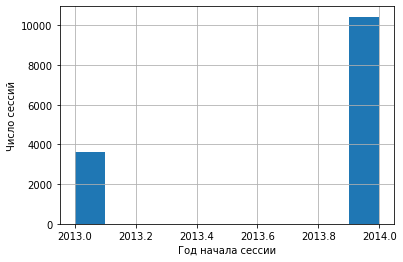

In [31]:
new_features_10users['year'].hist()
plt.xlabel('Год начала сессии')
plt.ylabel('Число сессий')

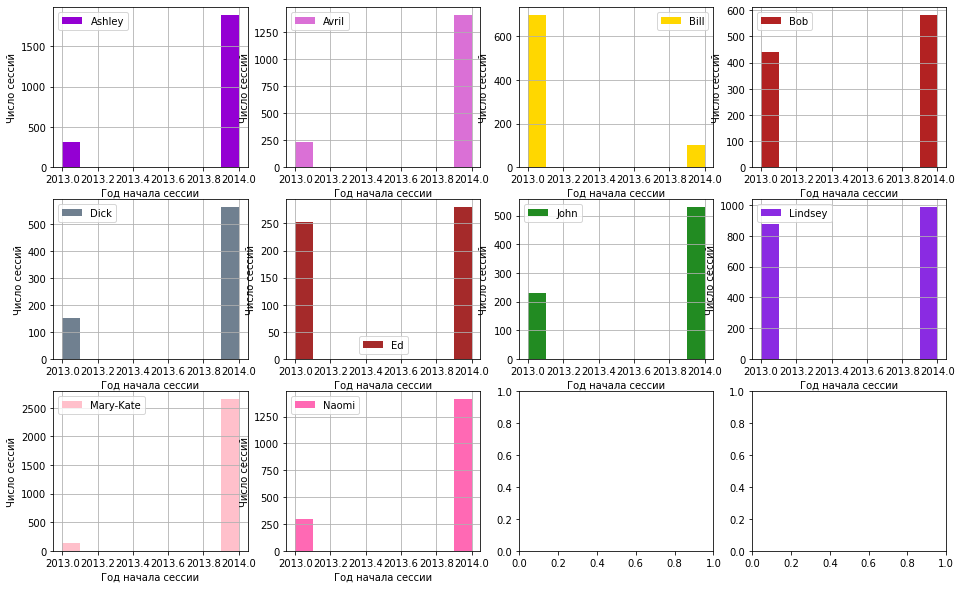

In [32]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))
axs = axes.ravel()

# как вариант, можно и по-другому
for idx, (user, sub_df) in  enumerate(new_features_10users.groupby('target')): 
  sub_df['year'].hist(color = color_dic[user], ax = axs[idx])
  axs[idx].set_xlabel('Год начала сессии')
  axs[idx].set_ylabel('Число сессий')
  axs[idx].legend([user])

Text(0, 0.5, 'Число сессий')

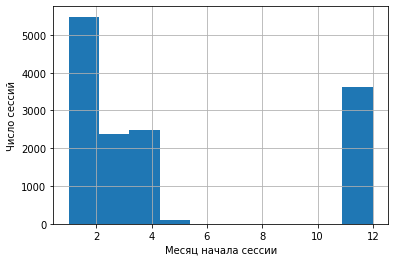

In [33]:
new_features_10users['month'].hist()
plt.xlabel('Месяц начала сессии')
plt.ylabel('Число сессий')

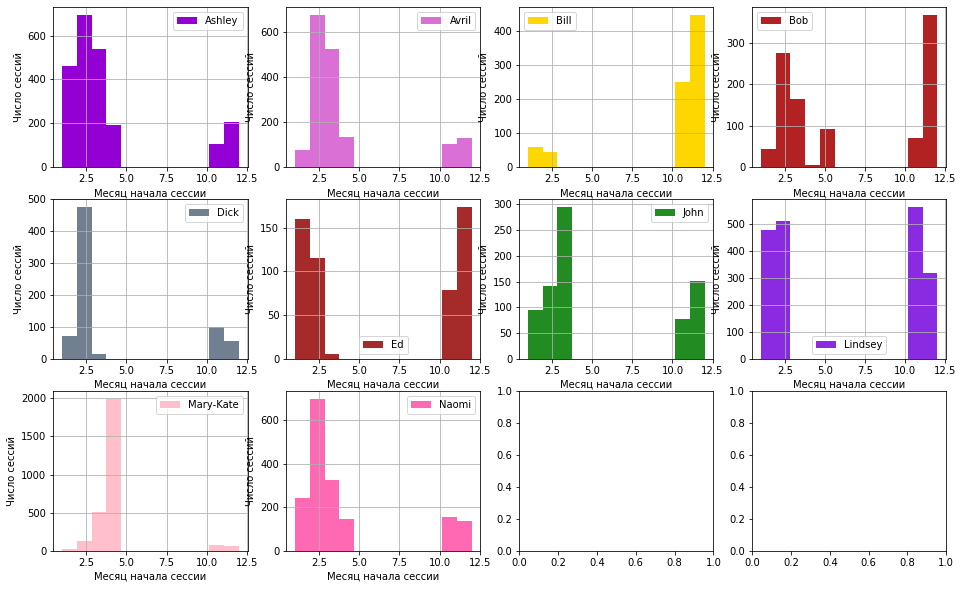

In [34]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))
axs = axes.ravel()

# как вариант, можно и по-другому
for idx, (user, sub_df) in  enumerate(new_features_10users.groupby('target')): 
  sub_df['month'].hist(color = color_dic[user], ax = axs[idx], bins=12)
  # axs[idx].set_xticklabels(['Январь', 'Февраль', 'Март', 'Апрель', 'Май', 'Июнь', 'Июль', 'Август', 'Сентябрь', 'Октябрь', 'Ноябрь', 'Декабрь'])
  axs[idx].set_xlabel('Месяц начала сессии')
  axs[idx].set_ylabel('Число сессий')
  axs[idx].legend([user])

Text(0, 0.5, 'Число сессий')

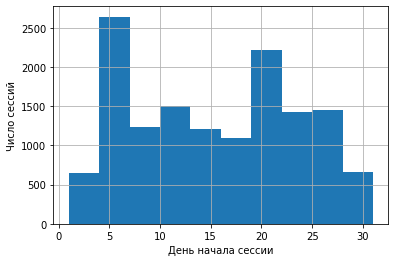

In [35]:
new_features_10users['day'].hist()
plt.xlabel('День месяца начала сессии')
plt.ylabel('Число сессий')

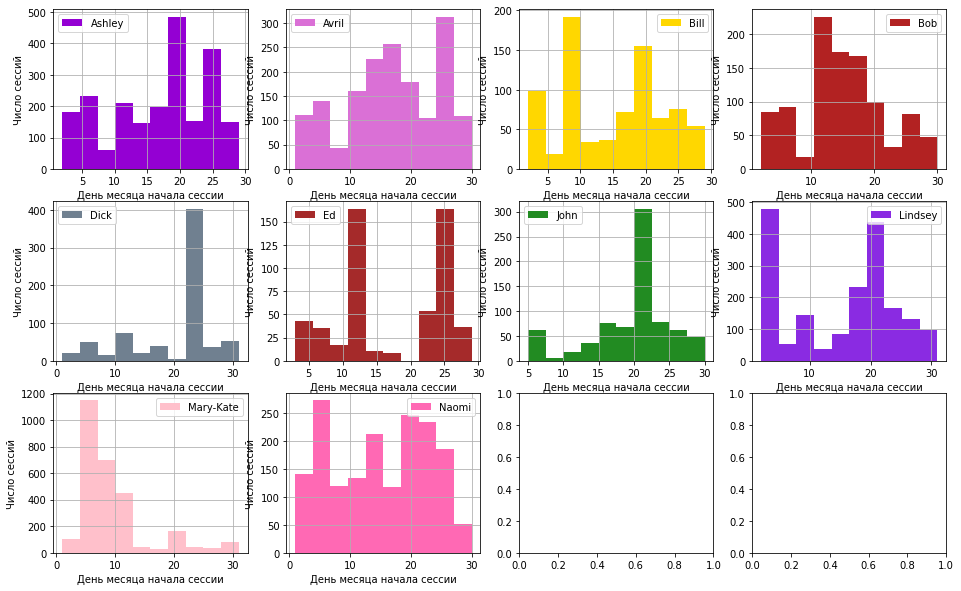

In [36]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))
axs = axes.ravel()

# как вариант, можно и по-другому
for idx, (user, sub_df) in  enumerate(new_features_10users.groupby('target')): 
  sub_df['day'].hist(color = color_dic[user], ax = axs[idx])
  axs[idx].set_xlabel('День месяца начала сессии')
  axs[idx].set_ylabel('Число сессий')
  axs[idx].legend([user])

Text(0, 0.5, 'Число сессий')

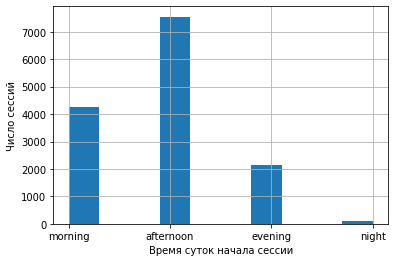

In [37]:
new_features_10users['part_of_day'].hist()
plt.xlabel('Время суток начала сессии')
plt.ylabel('Число сессий')

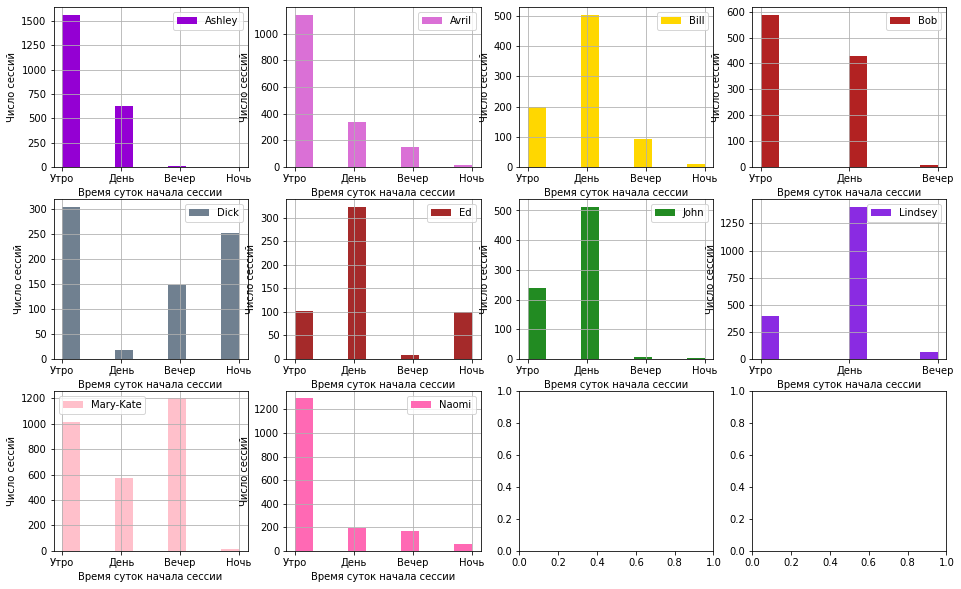

In [38]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))
axs = axes.ravel()

# как вариант, можно и по-другому
for idx, (user, sub_df) in  enumerate(new_features_10users.groupby('target')): 
  sub_df['part_of_day'].hist(color = color_dic[user], ax = axs[idx])
  axs[idx].set_xticklabels(['Утро', 'День', 'Вечер', 'Ночь'])
  axs[idx].set_xlabel('Время суток начала сессии')
  axs[idx].set_ylabel('Число сессий')
  axs[idx].legend([user])

Все признаки, кроме `year` могут быть полезны ввиду их повторяемости. Признак год начала сесии может быть оставлен только в случае построенния временного ряда. По полученным гистограммам можно заметить, что пользователи практически не сидят в интернете летом (основное время пребывания с октября по май). А время суток пользования приходится на день и утро. 

**В конце сохраните в pickle-файлы только те признаки, которые, как Вы предполагаете, помогут идентифицировать пользователя более точно. Это касается и признаков, которые мы вместе создали в начале (*session_timespan, #unique_sites, start_hour, day_of_week*), и Ваших собственных. Можно создать все эти признаки не только для сессий из 10 сайтов, но и для других сочетаний параметров *session_length* и *window_size*.**

In [39]:
selected_features_10users = new_features_10users.iloc[:, -9:-1]
selected_features_150users = new_features_150users.iloc[:, -9:-1]

In [40]:
with open(os.path.join(PATH_TO_DATA, 
                       'selected_features_10users.pkl'), 'wb') as selected_features_10users_pkl:
    pickle.dump(selected_features_10users, selected_features_10users_pkl, 
                protocol=2)
with open(os.path.join(PATH_TO_DATA, 
                       'selected_features_150users.pkl'), 'wb') as selected_features_150users_pkl:
    pickle.dump(selected_features_150users, selected_features_150users_pkl, 
                protocol=2)

### Критерии оценки работы (только для Peer Review в специализации):
- Верно ли отображена гистограмма session_timespan из п. 1? (max. 3 балла)
- Верно ли отображена гистограмма #unique_sites из п. 2? (max. 3 балла)
- Верно ли отображены гистограммы #unique_sites по каждому пользователю из п. 3? (max. 6 баллов)
- Верно ли отображена гистограмма start_hour из п. 4? (max. 3 балла)
- Верно ли отображены гистограммы start_hour по каждому пользователю из п. 5? (max. 6 баллов)
- Верно ли отображена гистограмма day_of_week из п. 6? (max. 3 балла)
- Верно ли отображены гистограммы day_of_week по каждому пользователю из п. 7? (max. 6 баллов)
- Насколько сделанные выводы в п. 8 соответствуют построенным картинкам? (max. 6 баллов)
- Верно ли отображен barplot для 10 популярных сайтов из п. 9? (max. 6 баллов)
- Правильно ли посчитана медианная продолжительность сессий в п. 10? (max. 3 балла)
- Правильно ли посчитан медианный день недели начала сессии в п. 11? (max. 3 балла)
- Правильно ли посчитан медианный час начала сессии в п. 12? (max. 3 балла)
- Правильно ли посчитано медианное значение числа уникальных сайтов в сессиях 150 пользователей п. 13? (max. 3 балла)
- Есть ли оригинальные построенные признаки и картинки к ним? Оцените также и качество картинок. (max. 8 баллов)

## Пути улучшения
Что еще можно добавить по 3 части проекта:
- IPython-widgets, интерактив и анимация (стоящие статьи по этому ремеслу – [раз](https://habrahabr.ru/post/308162/) и  [два](https://habrahabr.ru/company/ods/blog/323210/))
- можно попробовать изобразить исходные данные в некотором пространстве, например, Word2Vec, потом выделить главные компоненты или t-SNE  (только пользуйтесь эффективными реализациями типа [Multicore-TSNE](https://github.com/DmitryUlyanov/Multicore-TSNE), не Sklearn) и раскрасить по целевому классу. Но нет гарантий, что получится что-то значимо отличающееся от каши

На следующей неделе мы наконец приступим к обучению моделей классификации. 